In [12]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

current_palette = sns.color_palette()
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())

sns.set(rc={'figure.figsize':(20,4)}, font_scale=1.25, style='whitegrid', font='CMU Sans Serif')
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def save_fig(ax, folder, suffix, format="pdf"):
    fig = ax.get_figure()
    fig.tight_layout()

    fig.savefig(folder + suffix + "." + format)
    fig.clear()

In [13]:
df_paper = pd.DataFrame()

for experiment in ["server", "satellite"]:
    for run in ["1", "2", "3"]:
        
        #actual_start = max(df1["send_time"].min(), df2["send_time"].min(), df3["send_time"].min())
        #actual_end = min(df1["send_time"].max(), df2["send_time"].max(), df3["send_time"].max())
        
        #actual_length = actual_end - actual_start
        #print(actual_length/1e9)

        required_length = 10 * 60 * 1e9
        #cutoff = (actual_length - required_length) / 2

        expected_path = os.path.join("..", "results", experiment, run, "tracker.csv" )

        expected_df = pd.read_csv(expected_path)

        min_t = 0
        if experiment == "server":
            min_t = expected_df[expected_df["path1dist"] > 23.0]["t"].min()
        elif experiment == "satellite":
            min_t = expected_df[expected_df["path2dist"] > 2.0]["t"].min()


        start = min_t# + 100 * 1e9
        end = start + required_length

        expected_df["t"] = expected_df["t"] - start

        # cut off some stuff
        
        expected_df = expected_df[(0 <= expected_df["t"]) & (expected_df["t"] <= required_length)]

        
        for client in ["1", "2", "3"]:
            df = pd.read_csv(os.path.join("..", "results", experiment, run, client + ".csv" ))
            other_clients = df["id"].unique()
            
            actual_length = df["send_time"].max() - df["send_time"].min()
            print(actual_length/1e9)

            #df["send_time"] = df["send_time"] - min_t
            #df["recv_time"] = df["recv_time"] - min_t

            # cut off some stuff
            
            df = df[(start <= df["send_time"]) & (df["send_time"] <= end)]
            #df = df[df["latency"] < 500]

            actual_length = df["send_time"].max() - df["send_time"].min()
            print(actual_length/1e9)

            min_t_now = df["send_time"].min()
            df["send_time"] = df["send_time"] - min_t_now

            df["recv_time"] = df["recv_time"] - min_t_now

            actual_length = df["send_time"].max() - df["send_time"].min()
            print(actual_length/1e9)

            for other in other_clients:

                df_run = df[(df["id"] == other)][["latency", "send_time", "packet_len"]]
                # transform index into column and add other columns needed for the figure
                df_run.reset_index(inplace=True, drop=True)
                df_run.insert(0, "Experiment", experiment)
                df_run.insert(1, "Path", str(other) + "-" + client)
                df_run.insert(2, "Run", run)

                df_run["t"] = pd.to_datetime(df_run["send_time"])
                df_run.sort_values(by=["t"], inplace=True)
                df_run["latency_r"] = df_run.rolling('1s', min_periods=1, on="t").median()["latency"]
                df_run["latency_r_log10"] = np.log10(df_run["latency_r"])
                
                # set column names
                df_run.columns = ["Experiment", "Path", "Run", "Latency", "Time", "packet_len", "t", "Latency_Rolling", "Latency_Rolling_log10"]
                # calculate distribution
                #df_run.sort_values(by="t", ascending=True, inplace=True)
                # add to result df
                df_paper = df_paper.append(df_run)

#df_paper.sort_values(by=["Experiment", "t"], inplace=True)
df_paper.reset_index(inplace=True, drop=True) # optionally reset index

df_paper["Time"] = df_paper["Time"]/1e9
df_paper

647.660389888
597.411473408
597.411473408
648.358293504
597.999697664
597.999697664
648.358293504
597.999697664
597.999697664
647.854826752
597.69797632
597.69797632
645.08589056
594.79465216
594.79465216
647.972277248
597.69797632
597.69797632
651.542534656
599.996351232
599.996351232
646.372124416
599.993561088
599.993561088
651.542534656
599.996351232
599.996351232
657.630340864
599.991361536
599.991361536
657.76747904
599.984559616
599.984559616
651.335744768
599.990734848
599.990734848
656.747031552
599.994708224
599.994708224
654.019089152
599.983681536
599.983681536
656.659459328
599.994708224
599.994708224
653.648069888
599.99475968
599.99475968
658.515869184
599.977052416
599.977052416
658.196393472
599.998304
599.998304


,Experiment,Path,Run,Latency,Time,packet_len,t,Latency_Rolling,Latency_Rolling_log10
0,server,2-1,1,55.82,0.001655,124,1970-01-01 00:00:00.001654528,55.820,1.746790
1,server,2-1,1,46.92,0.032050,1236,1970-01-01 00:00:00.032050432,51.370,1.710710
2,server,2-1,1,46.64,0.044007,1236,1970-01-01 00:00:00.044007168,46.920,1.671358
3,server,2-1,1,46.72,0.055467,1236,1970-01-01 00:00:00.055467008,46.820,1.670431
4,server,2-1,1,46.95,0.055966,1236,1970-01-01 00:00:00.055965952,46.920,1.671358
...,...,...,...,...,...,...,...,...,...
6978375,satellite,2-3,3,14.92,599.995718,1235,1970-01-01 00:09:59.995717632,14.220,1.152900
6978376,satellite,2-3,3,14.16,599.996481,1235,1970-01-01 00:09:59.996480768,14.215,1.152747
6978377,satellite,2-3,3,13.66,599.996983,1235,1970-01-01 00:09:59.996982528,14.210,1.152594
6978378,satellite,2-3,3,13.25,599.997405,1236,1970-01-01 00:09:59.997405184,14.190,1.151982


In [14]:
df_paper["measurement"] = df_paper["Experiment"] + df_paper["Path"]

In [15]:
df_paper["Latency_Rolling_log10"] = np.log10(df_paper["Latency_Rolling"])

In [16]:
df_paper[(df_paper["Latency"] > 150)].count()



Experiment               2137
Path                     2137
Run                      2137
Latency                  2137
Time                     2137
packet_len               2137
t                        2137
Latency_Rolling          2137
Latency_Rolling_log10    2137
measurement              2137
dtype: int64

In [17]:
df_paper["Latency"].count()

6978380

<AxesSubplot:xlabel='t [s]', ylabel='Latency_Rolling'>

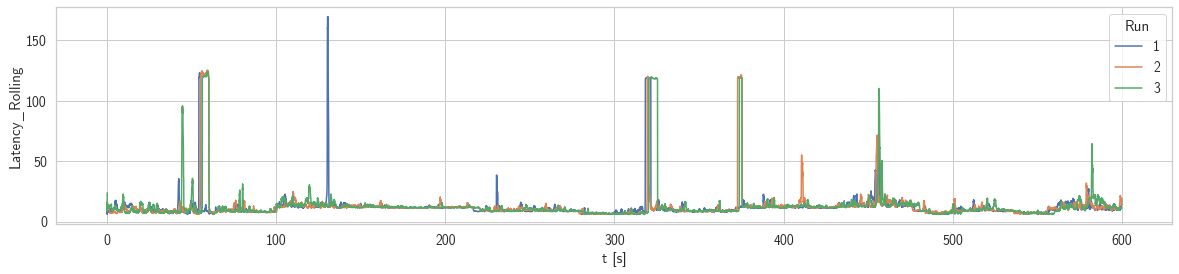

In [18]:
ax_paper = sns.lineplot(x="Time", y="Latency_Rolling", data=df_paper[(df_paper["Experiment"] == "satellite") & (df_paper["Path"] == "3-2")], hue="Run", hue_order=["1", "2", "3"], ci=None)
ax_paper.set_xlabel("t [s]")
ax_paper

<AxesSubplot:xlabel='t [s]', ylabel='Latency_Rolling'>

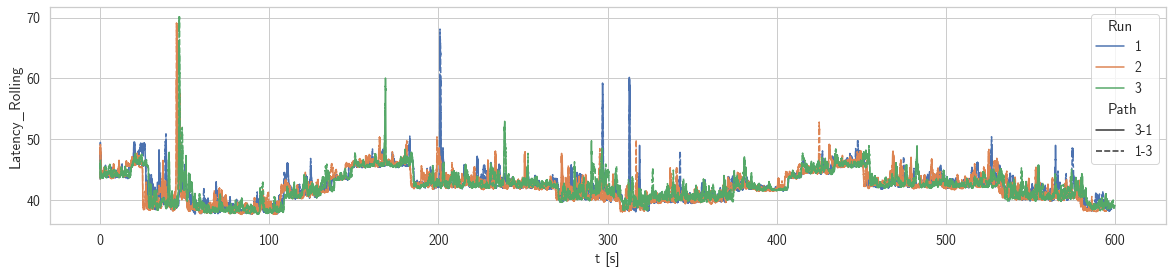

In [19]:
ax_paper = sns.lineplot(x="Time", y="Latency_Rolling", data=df_paper[(df_paper["Experiment"] == "server") & ((df_paper["Path"] == "3-1") | (df_paper["Path"] == "1-3"))], hue="Run", style="Path", ci=None)
ax_paper.set_xlabel("t [s]")
ax_paper

In [20]:
sns.set(rc={'figure.figsize':(10,4)}, font_scale=1.5, style='whitegrid', font='CMU Sans Serif')
ax_paper = sns.lineplot(x="Time", y="Latency_Rolling", data=df_paper[(df_paper["Experiment"] == "server") & (df_paper["Path"] == "3-1")], hue="Run", palette=sns.color_palette("Dark2", n_colors=3), hue_order=["1", "2", "3"], ci=None)
ax_paper.set_xlabel("t [s]")
ax_paper.set_ylabel("Latency\n(1s Rolling Median) [s]")
save_fig(ax_paper, "./paper/", "reproducibility-" + "server" + "-" + "3-2", format="pdf")
sns.set(rc={'figure.figsize':(20,4)}, font_scale=1.0, style='whitegrid', font='CMU Sans Serif')

webf NOT subset; don't know how to subset; dropped


<Figure size 720x288 with 0 Axes>

In [21]:
sns.color_palette("Dark2", n_colors=7)

[(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
 (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
 (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
 (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
 (0.4, 0.6509803921568628, 0.11764705882352941),
 (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
 (0.6509803921568628, 0.4627450980392157, 0.11372549019607843)]

In [22]:
for experiment in ["satellite", "server"]:
        for path in ["1-2", "1-3", "2-3", "2-1", "3-1", "3-2"]:

            ax_paper = sns.lineplot(x="Time", y="Latency_Rolling", data=df_paper[(df_paper["Experiment"] == experiment) & (df_paper["Path"] == path)], hue="Run", palette=sns.color_palette("Dark2", n_colors=3), hue_order=["1", "2", "3"], ci=None)
            ax_paper.set_xlabel("t [s]")
            ax_paper.set_ylabel("Latency (1s Rolling Median) [s]")
            save_fig(ax_paper, "./website/reproducibility/", "reproducibility-" + experiment + "-" + path, format="png")

            ax_paper = sns.lineplot(x="Time", y="Latency_Rolling_log10", data=df_paper[(df_paper["Experiment"] == experiment) & (df_paper["Path"] == path)], hue="Run", palette=sns.color_palette("Dark2", n_colors=3), hue_order=["1", "2", "3"], ci=None)
            ax_paper.set_xlabel("t [s]")
            ax_paper.set_ylabel("log10 Latency (1s Rolling Median)")
            save_fig(ax_paper, "./website/reproducibility/", "reproducibility-log10-" + experiment + "-" + path, format="png")

<Figure size 1440x288 with 0 Axes>